# attempt to read trajectories data from Alex Ruiz

In [20]:
# !/opt/venv/bin/python3 -m pip install --upgrade pip
# !pip install git+https://github.com/openptv/postptv.git@py3
# !pip install hdf5storage
# !pip install matplotlib
# !pip install scipy
# !pip install numpy

In [21]:
# Created a conda env called ptv and installed python 3.7.3

In [11]:
import numpy as np
# from scipy.io import loadmat
import matplotlib.pyplot as plt


In [12]:
import flowtracks
import h5py
import hdf5storage
import os
from flowtracks.trajectory import Trajectory

In [3]:
# For other MAT format, not v7.3 (HDF5)
# from flowtracks.io import trajectories_mat
# traj = trajectories_mat('traj_GT.mat')

In [13]:
print(os.listdir())

['.ipynb_checkpoints', 'debug.log', 'load_traj_h5.py', 'notebook.ipynb', 'read_alex_ruiz_data.ipynb', 'Read_Me.txt', 'traj.mat', 'traj_GT.mat', 'traj_pairs.py', 'traj_RC.mat']


In [14]:
def trajectories_mat_73(fname):
    """
    Extracts all trajectories from a Matlab file. the file is formated as a 
    list of trajectory record arrays, containing attributes 'xf', 'yf', 'zf'
    for position, 'uf', 'vf', 'wf' for velocity, and 'axf', 'ayf', 'azf' for
    acceleration.
    
    Modified by Alex Liberzon for v7.3 MAT files that cannot be loaded by
    scipy.io.loadmat but nicely by hdf5storage, e.g.:
    
        
        $ pip install hdf5storage
        
        trajects = trajectories_mat_73(fname)

    
    Arguments:
    fname - path to the Matlab file.
    
    Returns:
    trajects - a list of :class:`~flowtracks.trajectory.Trajectory` objects,
        one for each trajectory contained in the mat file.
    """

    data = hdf5storage.loadmat(os.path.expanduser(fname))
    
    # Get the workspace variable holding the trajectories:
    data_name = [s for s in data.keys() \
        if (not s.startswith('__')) and (not s == 'directory')][0]
    raw = np.hstack(data[data_name][0])
    
    trajects = []
    for traj in raw:
        # also convert data from mm to m.
        pos = np.hstack((traj['xf'], traj['yf'], traj['zf'])) # /1000. apparently it's already in mm
        vel = np.hstack((traj['uf'], traj['vf'], traj['wf'])) #/1000.
        accel = np.hstack((traj['axf'], traj['ayf'], traj['azf'])) # /1000.
        t = traj['t'].squeeze()
        trajid = traj['trajid'][0,0]
        trajects.append(Trajectory(pos, vel, t, trajid, accel=accel))
    
    return trajects

In [15]:
def trajectories_mat_h5py(fname):
    """
    Extracts all trajectories from a Matlab file. the file is formated as a 
    list of trajectory record arrays, containing attributes 'xf', 'yf', 'zf'
    for position, 'uf', 'vf', 'wf' for velocity, and 'axf', 'ayf', 'azf' for
    acceleration.

    Modified by Alex Liberzon for v7.3 MAT files that cannot be loaded by
    scipy.io.loadmat but nicely by h5py:


        trajects = trajectories_mat_h5py(fname)


    Arguments:
    fname - path to the Matlab file.

    Returns:
    trajects - a list of :class:`~flowtracks.trajectory.Trajectory` objects,
        one for each trajectory contained in the mat file.
    """

    with h5py.File(os.path.expanduser(fname),'r+') as f:

        # Get the workspace variable holding the trajectories:
        data_name = [s for s in f.keys() \
            if (not s.startswith('__')) and (not s == '#refs#')][0]
        # raw = np.hstack(data[data_name][0])

        ref = f[data_name] # reference only

        trajects = []
        
        # horizontal or vertical structure:
        
        if np.argmax(ref['t'].shape) == 0:
        
            for i in range(ref['t'].shape[0]):
                # also convert data from mm to m.
                pos = np.vstack((f[ref['xf'][i][0]][()],f[ref['yf'][i][0]][()],f[ref['zf'][i][0]][()])).T
                vel = np.vstack((f[ref['uf'][i][0]][()],f[ref['vf'][i][0]][()],f[ref['wf'][i][0]][()])).T
                accel = np.vstack((f[ref['axf'][i][0]][()],f[ref['ayf'][i][0]][()],f[ref['azf'][i][0]][()])).T
                t = f[ref['t'][i][0]][()].squeeze()
                trajid = f[ref['trajid'][i][0]][()][0]
                trajects.append(Trajectory(pos, vel, t, trajid, accel=accel))
        
        else:
        
            for i in range(ref['t'].shape[-1]):
                # also convert data from mm to m.
                pos = np.vstack((f[ref['xf'][0][i]][()],f[ref['yf'][0][i]][()],f[ref['zf'][0][i]][()])).T
                vel = np.vstack((f[ref['uf'][0][i]][()],f[ref['vf'][0][i]][()],f[ref['wf'][0][i]][()])).T
                accel = np.vstack((f[ref['axf'][0][i]][()],f[ref['ayf'][0][i]][()],f[ref['azf'][0][i]][()])).T
                t = f[ref['t'][0][i]][()].squeeze()
                trajid = f[ref['trajid'][0][i]][()][0]
                trajects.append(Trajectory(pos, vel, t, trajid, accel=accel))
    
    return trajects

In [16]:
trajects_GT = trajectories_mat_h5py('traj_GT.mat')

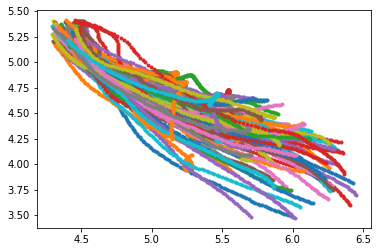

In [17]:
for traj in trajects_GT:
    # traj is a Trajectory object, supplied by the
    # flowtracks.trajectory module.
    plt.plot(traj.pos()[:,0], traj.pos()[:,1], '.')

plt.show()

In [18]:
trajects_RC = trajectories_mat_h5py('traj_RC.mat')

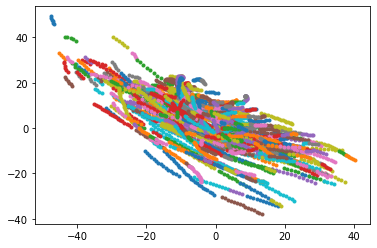

In [19]:
for traj in trajects_RC:
    # traj is a Trajectory object, supplied by the
    # flowtracks.trajectory module.
    plt.plot(traj.pos()[:,0], traj.pos()[:,1], '.')

plt.show()